In [1]:
# Handle different types of transformation
# different nb of pixels
# different nb of level of gray

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
# from sklearn import tree
import os
import random

mpl.rc('image', cmap='gray_r')
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense
from keras.models import load_model

C:\Users\MariO\Anaconda3\envs\PythonData\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Useful methods

In [2]:
def rot90ccw(mat):
    """ Rotate an n by n matrix 90 deg counter clock wise"""
    
    # rotation matrix
    rot = np.array([[0, 1],
               [-1,0]])
    # matrix coordinates
    coord = [i for i in np.ndindex(mat.shape)]
    nbp = mat.shape[0]    
    # initialisations
    coord_rot = []
    mat_rot = np.zeros((mat.shape))    
    # Apply the transformation on each pixel's coordinates
    for ii in range(0,len(coord)):
        # apply the rotation to the coordinate vector
        coord_rot.append(coord[ii]@rot)
        # reverse the row axis
        coord_rot[ii][0] += nbp-1
        # transform back into a tuple
        coord_rot[ii] = tuple(coord_rot[ii])   
        # fill up the rotated matrix
        mat_rot[coord_rot[ii]] = mat[coord[ii]]        
    
    return mat_rot

def rot90cw(mat):
    """ Rotate an n by n matrix 90 deg clock wise"""
    
    # rotation matrix
    rot = np.array([[0, -1],
               [1,0]])    
    # matrix coordinates
    coord = [i for i in np.ndindex(mat.shape)]
    nbp = mat.shape[0]    
    # initialisations
    coord_rot = []
    mat_rot = np.zeros((mat.shape))    
    # Apply the transformation on each pixel's coordinates
    for ii in range(0,len(coord)):
        # apply the rotation to the coordinate vector
        coord_rot.append(coord[ii]@rot)
        # reverse the row axis
        coord_rot[ii][1] += nbp-1
        # transform back into a tuple
        coord_rot[ii] = tuple(coord_rot[ii])   
        # fill up the rotated matrix
        mat_rot[coord_rot[ii]] = mat[coord[ii]]        
    
    return mat_rot

In [3]:
# Transformation matrices
def create_PPstar_translation(nbpix):
    # nb of pixels translated
    nbt = int(np.round(0.25*nbpix))

    # bottom left square block
    bl = np.eye(nbpix-nbt,nbpix-nbt)
    # upper right square block
    ur = np.eye(nbt,nbt)
    # upper left rect block
    ul = np.zeros((nbt,nbpix-nbt))
    # bottom right rect block
    br = np.zeros((nbpix-nbt,nbt))

    # concatenate the blocks to build the transformation matrix
    P = np.concatenate((np.concatenate((ul,ur), axis=1), np.concatenate((bl,br), axis=1)), axis=0)
    Pstar = np.linalg.inv(P)        
    return (P,Pstar)

def translate2left(mat):
    P,Pstar = create_PPstar_translation(mat.shape[0])
    return mat@P
def translate2right(mat):
    P,Pstar = create_PPstar_translation(mat.shape[0])
    return mat@Pstar


In [4]:
# plt.figure(1)
def remove_ticks():
    plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
    plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    labelleft=False,
    labelbottom=False) # labels along the bottom edge are off    
    return

def vis_matrices(Mr, Mm, Mst, MstM):
#     print(Mr.shape[0])
    if Mr.shape[0]==1:
        Mr = Mr.reshape(int(np.sqrt(Mr.shape[1])), int(np.sqrt(Mr.shape[1])))
        Mm = Mm.reshape(int(np.sqrt(Mm.shape[1])), int(np.sqrt(Mm.shape[1])))
        Mst = Mst.reshape(int(np.sqrt(Mst.shape[1])), int(np.sqrt(Mst.shape[1])))
        MstM = MstM.reshape(int(np.sqrt(Mst.shape[1])), int(np.sqrt(Mst.shape[1])))

    
    fig, (ax1,ax2) = plt.subplots(nrows=2,ncols=2) #, squeeze=True, sharey=True)
    fig.set_size_inches(8,8)

    plt.sca(ax1[0])
    plt.imshow(Mr)
    plt.title("Real image")
    remove_ticks()

    plt.sca(ax2[0])
    plt.imshow(Mm)
    plt.title("Distorted image")
    remove_ticks()

    plt.sca(ax1[1])
    plt.imshow(Mst)
    plt.title("Corrected input")
    remove_ticks()

    plt.sca(ax2[1])
    plt.imshow(MstM)
    plt.title("Corrected visualization")
    remove_ticks()

In [5]:
def create_training_data(nbpix,transform_type):
    """
    Build the set of one pixel matrices and apply the transformations
    """
    # List of indexes where to put a black pixel
    idx = range(0,nbpix**2,1)

    # Initialize empty arrays 
    Mreal_tab = np.zeros((len(idx),nbpix*nbpix))
    Mmang_tab = np.zeros((len(idx),nbpix*nbpix))
    Mstar_tab = np.zeros((len(idx),nbpix*nbpix))
    for ii in idx:
        # Fill the indexed pixel with a one
        Mreal_tab[ii,ii] = 1
        # Use the transformation matrices to generate Mmang and Mstar
#         Mmang_tab[ii,:] = (Mreal_tab[ii,:].reshape(nbpix,nbpix)@P).reshape(1,nbpix**2)
#         Mstar_tab[ii,:] = (Mreal_tab[ii,:].reshape(nbpix,nbpix)@Pstar).reshape(1,nbpix**2)
            
        if transform_type is "translation":    
            Mmang_tab[ii,:] = translate2left(Mreal_tab[ii,:].reshape(nbpix,nbpix)).reshape(1,nbpix**2)
            Mstar_tab[ii,:] = translate2right(Mreal_tab[ii,:].reshape(nbpix,nbpix)).reshape(1,nbpix**2)
        elif transform_type is "rotation":
            Mmang_tab[ii,:] = rot90ccw(Mreal_tab[ii,:].reshape(nbpix,nbpix)).reshape(1,nbpix**2)
            Mstar_tab[ii,:] = rot90cw(Mreal_tab[ii,:].reshape(nbpix,nbpix)).reshape(1,nbpix**2)
            
    return (Mreal_tab, Mmang_tab, Mstar_tab)

In [6]:
# Function to add one on the designated index
def add_one(arr,index):
    arr[0,index] = 1
    return arr

# Function to split the matrix into matrices of one pixel
def split_matrix(mat):
    """ Split a matrix into matrices of one pixel"""
    # find the indexes of the ones values in the matrix
#     idx_arr = np.where(mat.reshape(1,nbpix**2)[0]==1)[0]
    idx_arr = np.where(mat.reshape(1,nbpix**2)[0]>0)[0]
    # transform from an array to a list
    idx_lst = [idx_arr.item(ii) for ii in range(0,len(idx_arr))] 
    temp = np.zeros((1,nbpix**2))
    mat_split = np.zeros((len(idx_lst), nbpix**2))
#     Mtest = np.zeros((nbpix,nbpix))
    for ii in range(0,len(idx_lst)):
        mat_split[ii,idx_lst[ii]] = 1    
#         Mtest = Mtest + Mreal_split[ii,:].reshape(nbpix,nbpix)
    return mat_split

In [16]:
# Prediction functions
def perform_prediction(mat, model):
    """ Predict the output with a trained model"""
    # split the input matrix into matrices of one pixel
    mat_split = split_matrix(mat)
    nb_dark_pxl = mat_split.shape[0]
    
    # initializations
    res = np.zeros((nb_dark_pxl, nbpix**2))
    Mres = np.zeros((nbpix,nbpix))
    # Loop on all the one pixels array
    for ii in range(0,nb_dark_pxl):
        # Apply the models to the one pixel matrices
        print(mat_split[ii])
        res[ii,:] = model.predict(np.expand_dims(mat_split[ii], axis=0))
        # Sum up the results to construct the matrices
        Mres = Mres + res[ii,:].reshape(nbpix,nbpix)
    return Mres

# def predict_corrector(mat):
#     # split the input matrix into matrices of one pixel
#     mat_split = split_matrix(mat)
#     nb_dark_pxl = mat_split.shape[0]
    
#     # initializations
#     res = np.zeros((nb_dark_pxl, nbpix**2))
#     Mres = np.zeros((nbpix,nbpix))
#     # Loop on all the one pixels array
#     for ii in range(0,nb_dark_pxl):
#         # Apply the models to the one pixel matrices
#         res[ii,:] = model_corrector.predict(np.expand_dims(mat_split[ii], axis=0))
#         # Sum up the results to construct the matrices
#         Mres = Mres + res[ii,:].reshape(nbpix,nbpix)
#     return Mres

In [8]:
def create_door_img(nbpix):
    """ Create an nbpix by nbpix image of a door"""
    nbborder = int(np.round(nbpix*0.3))
    u = np.ones((nbborder,nbpix))
    l = np.ones((nbpix-nbborder,nbborder))
    r = l
    door = np.zeros((nbpix-nbborder, nbpix-2*nbborder))

    return np.concatenate((u,np.concatenate((l,door,r), axis=1)), axis=0)

In [9]:


# def grayscale_cmap(cmap):
#     """Return a grayscale version of the given colormap"""
#     cmap = plt.cm.get_cmap(cmap)
#     colors = cmap(np.arange(cmap.N))
    
#     # convert RGBA to perceived grayscale luminance
#     # cf. http://alienryderflex.com/hsp.html
#     RGB_weight = [0.299, 0.587, 0.114]
#     luminance = np.sqrt(np.dot(colors[:, :3] ** 2, RGB_weight))
#     colors[:, :3] = luminance[:, np.newaxis]
        
#     return LinearSegmentedColormap.from_list(cmap.name + "_gray", colors, cmap.N)

# mpl.rc('image', cmap=grayscale_cmap("viridis_r"))
   

 ## MAIN

In [18]:
# Parameters
nbpix = 4 # nb of pixel to consider (nbpix x nbpix)
transform_type = "rotation" # type of transformation : "translation" or "rotation"
training_type = "full" # type of training: "partial" of "full"

In [11]:
# create the transformation matrices

# import random
# (P,Pstar) = create_PPstar(nbpix)

# Create the training data
(Mreal_tab, Mmang_tab, Mstar_tab) = create_training_data(nbpix,transform_type)


# the training input are the matrices of the real images with one pixel

if training_type is "partial": # we remove randomly 20% of the training data
    # rebuild the list of indexes and shuffle it
    rdm_idx = list(range(0,nbpix**2,1))
    random.shuffle(rdm_idx)
    
    # remove 80% of the indexes of this list
    rdm_idx[0:int(np.round(nbpix**2*0.8))] = []
    
    # delete the corresponding rows in the training matrices
    Mreal_tab = np.delete(Mreal_tab, rdm_idx, axis=0)
    Mmang_tab = np.delete(Mmang_tab, rdm_idx, axis=0)
    Mstar_tab = np.delete(Mstar_tab, rdm_idx, axis=0)
    
    print(f"Training performed on {Mreal_tab.shape[0]}/{Mreal_tab.shape[1]} pixels")

idx = range(0,Mreal_tab.shape[0],1)        
X_train = Mreal_tab   


In [12]:
# the training output will be the category corresponding to the position of the pixel in the mangled image
y_train = [np.where(Mmang_tab[ii,:]==1)[0].item(0) for ii in idx]
y_train = to_categorical(y_train, nbpix**2)

# or the position of the pixel in the corrected image
y_train_cor = [np.where(Mstar_tab[ii,:]==1)[0].item(0) for ii in idx]
y_train_cor = to_categorical(y_train_cor, nbpix**2)

# creating the models
model_mangler = Sequential()
model_mangler.add(Dense(4*nbpix**2, activation='relu', input_dim=nbpix**2))
model_mangler.add(Dense(4*nbpix**2, activation='relu'))
model_mangler.add(Dense(nbpix**2, activation='softmax'))
# Inversion strategy doesnt work very well...
# we are going to try using another model, trained on the corrected input.
model_corrector = Sequential()
model_corrector.add(Dense(4*nbpix**2, activation='relu', input_dim=nbpix**2))
model_corrector.add(Dense(4*nbpix**2, activation='relu'))
model_corrector.add(Dense(nbpix**2, activation='softmax'))

# Compile the models
model_mangler.compile(loss="categorical_crossentropy",
              optimizer="adam", metrics=['accuracy'])
model_corrector.compile(loss="categorical_crossentropy",
              optimizer="adam", metrics=['accuracy'])

# train the model "mangler"
model_mangler.fit( X_train,
    y_train,
    epochs=5*nbpix**2,
    shuffle=True,
    verbose=1
)

# train the corrected input model
model_corrector.fit( X_train,
    y_train_cor,
    epochs=5*nbpix**2,
    shuffle=True,
    verbose=1
)    

# model_mangler.summary()
# model_corrector.summary()

# Save the models
model_mangler.save(f"{transform_type}_{training_type}_mangler_{nbpix}x{nbpix}.h5")
model_corrector.save(f"{transform_type}_{training_type}_corrector_{nbpix}x{nbpix}.h5")

Epoch 1/180
36/36 [==============================] - 0s 8ms/step - loss: 3.5877 - acc: 0.0278
Epoch 2/180
36/36 [==============================] - 0s 194us/step - loss: 3.5535 - acc: 0.1111
Epoch 3/180
36/36 [==============================] - 0s 250us/step - loss: 3.5275 - acc: 0.2222
Epoch 4/180
36/36 [==============================] - 0s 250us/step - loss: 3.5056 - acc: 0.2222
Epoch 5/180
36/36 [==============================] - 0s 194us/step - loss: 3.4837 - acc: 0.3333
Epoch 6/180
36/36 [==============================] - 0s 194us/step - loss: 3.4619 - acc: 0.3889
Epoch 7/180
36/36 [==============================] - 0s 194us/step - loss: 3.4405 - acc: 0.5833
Epoch 8/180
36/36 [==============================] - 0s 278us/step - loss: 3.4190 - acc: 0.6389
Epoch 9/180
36/36 [==============================] - 0s 222us/step - loss: 3.3973 - acc: 0.6667
Epoch 10/180
36/36 [==============================] - 0s 167us/step - loss: 3.3758 - acc: 0.7500
Epoch 11/180
36/36 [=====================

36/36 [==============================] - 0s 194us/step - loss: 0.1397 - acc: 1.0000
Epoch 86/180
36/36 [==============================] - 0s 389us/step - loss: 0.1320 - acc: 1.0000
Epoch 87/180
36/36 [==============================] - 0s 167us/step - loss: 0.1250 - acc: 1.0000
Epoch 88/180
36/36 [==============================] - 0s 306us/step - loss: 0.1188 - acc: 1.0000
Epoch 89/180
36/36 [==============================] - 0s 194us/step - loss: 0.1131 - acc: 1.0000
Epoch 90/180
36/36 [==============================] - 0s 278us/step - loss: 0.1078 - acc: 1.0000
Epoch 91/180
36/36 [==============================] - 0s 333us/step - loss: 0.1029 - acc: 1.0000
Epoch 92/180
36/36 [==============================] - 0s 222us/step - loss: 0.0981 - acc: 1.0000
Epoch 93/180
36/36 [==============================] - 0s 333us/step - loss: 0.0937 - acc: 1.0000
Epoch 94/180
36/36 [==============================] - 0s 250us/step - loss: 0.0893 - acc: 1.0000
Epoch 95/180
36/36 [=======================

36/36 [==============================] - 0s 222us/step - loss: 0.0162 - acc: 1.0000
Epoch 169/180
36/36 [==============================] - 0s 167us/step - loss: 0.0160 - acc: 1.0000
Epoch 170/180
36/36 [==============================] - 0s 167us/step - loss: 0.0157 - acc: 1.0000
Epoch 171/180
36/36 [==============================] - 0s 194us/step - loss: 0.0155 - acc: 1.0000
Epoch 172/180
36/36 [==============================] - 0s 139us/step - loss: 0.0153 - acc: 1.0000
Epoch 173/180
36/36 [==============================] - 0s 167us/step - loss: 0.0151 - acc: 1.0000
Epoch 174/180
36/36 [==============================] - 0s 139us/step - loss: 0.0149 - acc: 1.0000
Epoch 175/180
36/36 [==============================] - 0s 139us/step - loss: 0.0146 - acc: 1.0000
Epoch 176/180
36/36 [==============================] - 0s 194us/step - loss: 0.0145 - acc: 1.0000
Epoch 177/180
36/36 [==============================] - 0s 250us/step - loss: 0.0143 - acc: 1.0000
Epoch 178/180
36/36 [=============

36/36 [==============================] - 0s 167us/step - loss: 0.3622 - acc: 1.0000
Epoch 73/180
36/36 [==============================] - 0s 167us/step - loss: 0.3328 - acc: 1.0000
Epoch 74/180
36/36 [==============================] - 0s 167us/step - loss: 0.3072 - acc: 1.0000
Epoch 75/180
36/36 [==============================] - 0s 139us/step - loss: 0.2833 - acc: 1.0000
Epoch 76/180
36/36 [==============================] - 0s 250us/step - loss: 0.2607 - acc: 1.0000
Epoch 77/180
36/36 [==============================] - 0s 222us/step - loss: 0.2420 - acc: 1.0000
Epoch 78/180
36/36 [==============================] - 0s 167us/step - loss: 0.2245 - acc: 1.0000
Epoch 79/180
36/36 [==============================] - 0s 139us/step - loss: 0.2098 - acc: 1.0000
Epoch 80/180
36/36 [==============================] - 0s 278us/step - loss: 0.1956 - acc: 1.0000
Epoch 81/180
36/36 [==============================] - 0s 222us/step - loss: 0.1827 - acc: 1.0000
Epoch 82/180
36/36 [=======================

36/36 [==============================] - 0s 167us/step - loss: 0.0196 - acc: 1.0000
Epoch 156/180
36/36 [==============================] - 0s 250us/step - loss: 0.0193 - acc: 1.0000
Epoch 157/180
36/36 [==============================] - 0s 222us/step - loss: 0.0190 - acc: 1.0000
Epoch 158/180
36/36 [==============================] - 0s 222us/step - loss: 0.0187 - acc: 1.0000
Epoch 159/180
36/36 [==============================] - 0s 194us/step - loss: 0.0184 - acc: 1.0000
Epoch 160/180
36/36 [==============================] - 0s 194us/step - loss: 0.0182 - acc: 1.0000
Epoch 161/180
36/36 [==============================] - 0s 306us/step - loss: 0.0179 - acc: 1.0000
Epoch 162/180
36/36 [==============================] - 0s 361us/step - loss: 0.0176 - acc: 1.0000
Epoch 163/180
36/36 [==============================] - 0s 333us/step - loss: 0.0174 - acc: 1.0000
Epoch 164/180
36/36 [==============================] - 0s 139us/step - loss: 0.0171 - acc: 1.0000
Epoch 165/180
36/36 [=============

In [19]:
# Apply the models to an existing image

# Load the saved models
model_mangler = load_model(f"{transform_type}_{training_type}_mangler_{nbpix}x{nbpix}.h5")
model_corrector = load_model(f"{transform_type}_{training_type}_corrector_{nbpix}x{nbpix}.h5")

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


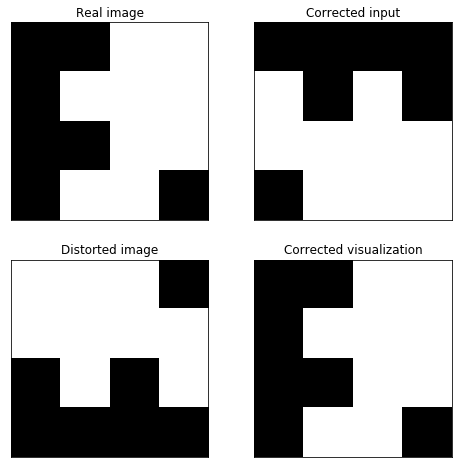

In [20]:
# Mreal = create_door_img(nbpix) 
cut = 0.5
Mreal = np.random.choice([0, 1], size=(nbpix,nbpix), p=[ 1-cut, cut])
# Mreal_split = split_matrix(Mreal)

# Predict the mangled image based on the real one
Mmang_ml = perform_prediction(Mreal,model_mangler ) # predict_mangler(Mreal)
# Predict the corrected input based on the real image
Mcor_ml = perform_prediction(Mreal, model_corrector)# predict_corrector(Mreal)
# Prediction of the output from the corrected input
Mout_ml = perform_prediction(np.round(Mcor_ml), model_mangler)
# plot the results
# vis_matrices(Mreal, Mmang_ml,Mcor_ml, Mout_ml)
if transform_type is "translation":
    vis_matrices(Mreal, Mmang_ml,Mcor_ml, translate2left(Mcor_ml))
elif transform_type is "rotation":
    vis_matrices(Mreal, Mmang_ml,Mcor_ml, rot90ccw(Mcor_ml))


In [27]:
# vis_matrices(Mreal, rot90ccw(Mreal),rot90cw(Mreal), rot90ccw(rot90cw(Mreal)))

from flask import jsonify
import json

import numpy as np
import codecs, json 

a = np.arange(10).reshape(2,5) # a 2 by 5 array
b = a.tolist() # nested lists with same data, indices
file_path = "/path.json" ## your path variable
json.dump(b, codecs.open(file_path, 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=True, indent=4) ### this saves the array in .json format

In [30]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

a = np.array([[1, 2, 3], [4, 5, 6]])
print(a.shape)

# json_dump = json.dumps({'a': a, 'aa': [2, (2, 3, 4), a], 'bb': [2]}, cls=NumpyEncoder)
json_dump = json.dumps({"mat": Mreal}, cls=NumpyEncoder)
print(json_dump)

(2, 3)
{"mat": [[0, 0, 0, 1], [0, 0, 1, 1], [1, 1, 0, 0], [0, 0, 1, 1]]}


In [49]:
cut = 0.5
print(nbpix)
rmd_img = np.random.choice([0, 1], size=(nbpix,nbpix), p=[ 1-cut, cut])
print(np.random.choice([0, 1], size=(nbpix,nbpix), p=[ 1-cut, cut]))
json_dump = json.dumps({"a": rmd_img} , cls=NumpyEncoder)
print(json_dump)

4
[[0 0 0 0]
 [1 0 0 0]
 [1 1 1 0]
 [1 1 1 0]]
{"a": [[1, 0, 0, 1], [0, 1, 0, 1], [1, 0, 1, 1], [1, 1, 0, 1]]}


In [50]:
import pandas as pd
pd.Series(json_dump).to_json(orient='values')

'["{\\"a\\": [[1, 0, 0, 1], [0, 1, 0, 1], [1, 0, 1, 1], [1, 1, 0, 1]]}"]'

In [78]:
def arrayToList(arr):
    return [ii.item() for ii in arr.reshape((arr.size,1))]

In [75]:
# transform into a list
mat_list = [ii.item() for ii in Mreal.reshape((nbpix**2,1))]

In [77]:
arrayToList(Mreal)
# Mreal.size

[[0 0 0 1]
 [0 0 1 1]
 [1 1 0 0]
 [0 0 1 1]]
16


[0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1]

In [79]:
np.arange(4,16,2)

array([ 4,  6,  8, 10, 12, 14])

In [80]:
arrayToList(np.arange(4,16,2))

[4, 6, 8, 10, 12, 14]